# EXPLANATION
This script performs GWAS on a pre-selected number of variants (in Plink binary format) and on a specific phenotype you want. Ideally, the phenotype has been adjusted for inversions, infection, and also log-transformed if the raw phenotype wasn't deemed normally distributed.

BEWARE: You should format your phenotype line IDs in the same way as denoted in the .fam variant file you are using.

 # Time measurement


In [2]:
import time
start = time.clock()
print 'hi'

hi


# Importing, general preparations

In [3]:
import os
os.chdir('FaST_LMM')

from fastlmm.association import single_snp
from fastlmm.inference.fastlmm_predictor import _snps_fixup, _pheno_fixup, _kernel_fixup, _SnpTrainTest
from random import shuffle
import numpy as np
import pandas as pd
import time
import os
# We're going to need PySnpTools, to do permutations, because we can shuffle bed files by varint using Bed
import sys
sys.path.append('../PySnpTools')
from pysnptools.snpreader import Bed
from shutil import copyfile

C:\Users\micha\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\micha\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# CONSTANTS 

In [4]:
# Permutation info
NUMBER_OF_PERMUTATIONS = 0
# Where you want to save your phenotype
OUTPUT_NAME = '../Outputs/GWASMay'

# INPUTS 

In [7]:
# Phenotype data to test
#phenotype_data = '../Outputs/Fast-Lmm-Input-Interocular-Distance-Vonesch2016-Female.txt'
phenotype_data = '../Outputs/Fast-Lmm-Input-Mass-Female.txt'
#phenotype_data = '../Outputs/Dgrp2-AllLines-RandomPheno-for-Mito.txt'
#phenotype_data = '../Outputs/T5-Pheno-for-Fast-Lmm-DGRPFormat.txt'
#phenotype_data = '../Outputs/T5-Pheno-for-Fast-Lmm.txt'


# Variants to test your phenotype on
#variants_to_test = '../Outputs/MitoSeq_AllRuns_dm6_chrM.annot.biallellic_ConvertedReference'
#variants_to_test = '../Data/dgrp2'
#variants_to_test = '../Outputs/Plinkfiles/DGRP2Chr2R'
variants_to_test = '../Outputs/MassVariants_MAF5'
#variants_to_test = '../Outputs/Plinkfiles/Dgrp2-CSLines-Maf5'


# ACTUAL GWAS =================================================================

# Clearing cache
# This ensures that the relationship matrix is recalculated for each phenotype.
try:
    os.remove('Outputs/Fast-Lmm-Cache/Gwas-Permutations-Cache.npz')
except OSError:
    pass



# Performing GWAS on the real phenotype:

time_0 = time.time()
results_df = single_snp(variants_to_test,  phenotype_data,
                        cache_file='Outputs/Fast-Lmm-Cache/Gwas-Permutations-Cache.npz',
                        leave_out_one_chrom=False,
                        save_test_statistic=True,
                        output_file_name = OUTPUT_NAME + '-Original.txt',
                        )
time_1 = time.time()

print('Time for full GWAS:' + str(time_1 - time_0) + 's')
print 'Total time: ' + str(time.clock()-start)

NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SNP)
NaN beta value seen, may be due to an SNC (a constant SN

In [8]:
test_stat = pd.read_csv('../Outputs/Fast-Lmm-Cache/Test-Stat-Cache.txt', header=None)
test_stat = test_stat.replace('[\[\] ]', '', regex=True)
test_stat = pd.to_numeric(test_stat[0])

results_df['Full ID'] = results_df['Chr'].astype('str') + '_' + results_df['ChrPos'].astype('str')
results_df = pd.concat([results_df[['Chr', 'ChrPos', 'SNP', 'Full ID', 'PValue']], test_stat],
                       axis = 1)
results_df.columns = ['Chr', 'ChrPos', 'SNP', 'Full ID', 'PValue', 'F-test statistic']

mybed = Bed(variants_to_test + '.bed')
mysnpdata = mybed.read()

In [9]:
pheno = _pheno_fixup(phenotype_data, count_A1=None).read()
pheno = pheno.val[np.searchsorted(pheno.iid[:,1], mysnpdata.iid[:,1])]
snpdata = mysnpdata.val
diff = range(snpdata.shape[1])
maf = range(snpdata.shape[1])
n_alleles = range(snpdata.shape[1])
mean_major = range(snpdata.shape[1])
for i in range(snpdata.shape[1]):
    ref = [j for j, x in enumerate(snpdata[:,i]) if x == 2]
    alt = [j for j, x in enumerate(snpdata[:,i]) if x == 0]
    meanref = np.mean(pheno[ref])
    meanalt = np.mean(pheno[alt])
    if len(ref) > len(alt):
        diff[i] = meanref - meanalt
        maf[i] = float(len(alt)) / (len(ref) + len(alt))
        n_alleles[i] = len(ref) + len(alt)
        mean_major[i] = meanref
    elif len(ref) + len(alt) == 0:
        diff[i] = float('NaN')
        maf[i] = float('NaN')
        n_alleles[i] = len(ref) + len(alt)
        mean_major[i] = float('NaN')
    else:
        diff[i] = meanalt - meanref
        maf[i] = float(len(ref)) / (len(ref) + len(alt))
        n_alleles[i] = len(ref) + len(alt)
        mean_major[i] = meanalt

C:\Users\micha\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\micha\Anaconda2\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
diff_df = diff_df = pd.DataFrame(data={'MajMinDiff':diff,
                                       'MeanMajor': mean_major,
                                       'MAF':maf,
                                       'NAlleles':n_alleles})
diff_df['SNP'] = mysnpdata.sid
results_df = pd.merge(results_df, diff_df, on='SNP')
    

# PHENOTYPE shuffling/permutation and adding the p-values from the resulting
# GWAS to the results data frame.
#phenotype_to_shuffle = pd.read_table(phenotype_data,
#                                     sep=' ', header=None)
#indices = range(len(phenotype_to_shuffle))
#temp_shuffled_pheno = '../Outputs/Fast-Lmm-Inputs/Temporary-Shuffled-Phenotype.txt'
#
#for i in range(NUMBER_OF_PERMUTATIONS):
#    time_permut_0 = time.time()
#    shuffle(indices)
#    phenotype_shuffled = []
#    for j in range(len(indices)):
#        phenotype_shuffled.append(phenotype_to_shuffle[2][indices[j]])
#    
#    phenotype_to_shuffle[2] = phenotype_shuffled
#    phenotype_to_shuffle.to_csv(temp_shuffled_pheno, header=False, index=False, sep=' ')
#    tmp_shuffled_df = single_snp(variants_to_test,  temp_shuffled_pheno,
##                                cache_file='../Outputs/Fast-Lmm-Cache/Gwas-Permutations-Cache'+str(i)
#                                 cache_file='../Outputs/Fast-Lmm-Cache/Gwas-Permutations-Cache.npz',
#                                 leave_out_one_chrom=False,
#                                 )
#    tmp_shuffled_df['Full ID'] = tmp_shuffled_df['Chr'].astype('str') + '_' + tmp_shuffled_df['ChrPos'].astype('str')
#    
#    # sorting the new df to match the original
#    tmp_shuffled_df = tmp_shuffled_df[['Full ID', 'PValue']]
#    tmp_shuffled_df['PValue'].rename('PValueShuffled'+str(i+1))
#    
#    
#    results_df = pd.merge(results_df, tmp_shuffled_df, on='Full ID')
#    print('Time for permutation GWAS:' + str(time.time() - time_permut_0) + 's')

In [12]:
# Shuffling ALLELES by VARIANT

for i in range(NUMBER_OF_PERMUTATIONS):
    time_permut_0 = time.time()
    
    # Python works a little different than R: Shuffle directly modifies the input data frame!
    np.random.shuffle(mysnpdata.val)
    Bed.write('VariantsPermuted', mysnpdata)
    copyfile(variants_to_test + '.bim', 'VariantsPermuted.bim')

    tmp_shuffled_df = single_snp('VariantsPermuted',  phenotype_data,
#                                cache_file='../Outputs/Fast-Lmm-Cache/Gwas-Permutations-Cache'+str(i)
                                 cache_file='../Outputs/Fast-Lmm-Cache/Gwas-Permutations-Cache.npz',
                                 leave_out_one_chrom=False,
                                 )
    tmp_shuffled_df['Full ID'] = tmp_shuffled_df['Chr'].astype('str') + '_' + tmp_shuffled_df['ChrPos'].astype('str')
    
    # sorting the new df to match the original
    tmp_shuffled_df = tmp_shuffled_df[['Full ID', 'SNP', 'PValue']]
    tmp_shuffled_df = tmp_shuffled_df.rename(columns={'Full ID':'Full IDShuffled'+str(i+1),
                                                      'PValue':'PValueShuffled'+str(i+1)})
    
    snpdata = mysnpdata.val
    diff = range(snpdata.shape[1])
    maf = range(snpdata.shape[1])
    n_alleles = range(snpdata.shape[1])
    mean_major = range(snpdata.shape[1])
    for k in range(snpdata.shape[1]):
        ref = [j for j, x in enumerate(snpdata[:,k]) if x == 2]
        alt = [j for j, x in enumerate(snpdata[:,k]) if x == 0]
        meanref = np.mean(pheno[ref])
        meanalt = np.mean(pheno[alt])
        if len(ref) > len(alt):
            diff[k] = meanref - meanalt
            maf[k] = float(len(alt)) / (len(ref) + len(alt))
            n_alleles[k] = len(ref) + len(alt)
            mean_major[k] = meanref
        elif len(ref) + len(alt) == 0:
            diff[k] = float('NaN')
            maf[k] = float('NaN')
            n_alleles[k] = len(ref) + len(alt)
            mean_major[k] = float('NaN')
        else:
            diff[k] = meanalt - meanref
            maf[k] = float(len(ref)) / (len(ref) + len(alt))
            n_alleles[k] = len(ref) + len(alt)
            mean_major[k] = meanalt
        
    diff_df = diff_df = pd.DataFrame(data={'MajMinDiffShuffled'+str(i+1):diff,
                                           'MeanMajorShuffled'+str(i+1): mean_major,
                                           'NAllelesShuffled'+str(i+1):n_alleles,
                                           'MAFShuffled'+str(i+1):maf})
    diff_df['SNP'] = mysnpdata.sid
    tmp_shuffled_df = pd.merge(tmp_shuffled_df, diff_df, on='SNP')
    tmp_shuffled_df = tmp_shuffled_df.rename(columns={'SNP':'SNPShuffled'+str(i+1)})
    
#    results_df = pd.merge(results_df, tmp_shuffled_df, on='Full ID')
    results_df = results_df.join(tmp_shuffled_df)
    print('Time for permutation GWAS:' + str(time.time() - time_permut_0) + 's')    

In [13]:
results_df.to_csv(OUTPUT_NAME + '-with-Permutations.txt', sep="\t", index=False)

# Manhattan Plot

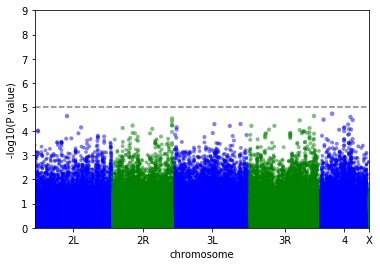

In [20]:
import pylab
import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False, plot_threshold=1)
pylab.show()

# QQ Plot

C:\Users\micha\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\micha\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
fastlmm\feature_selection\PerformSelectionDistributable.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\micha\Anaconda2\lib\runpy.py", line 17

lambda=1.0020


C:\Users\micha\Anaconda2\lib\site-packages\numpy\lib\scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


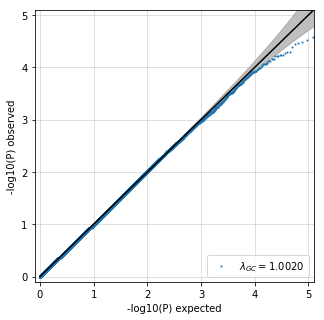

In [22]:
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])
pylab.show()

In [ ]:
%ls

# The end